In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('Data/creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
data.shape

(284807, 31)

## Exploratory Data Analaysis

In [4]:
data[['Time','Amount','Class']].describe().T

,count,mean,std,min,25%,50%,75%,max
Time,284807.0,94813.859575,47488.145955,0.0,54201.5,84692.0,139320.500,172792.00
Amount,284807.0,88.349619,250.120109,0.0,5.6,22.0,77.165,25691.16
Class,284807.0,0.001727,0.041527,0.0,0.0,0.0,0.000,1.00


In [5]:
data[['Time','Amount','Class']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   Amount  284807 non-null  float64
 2   Class   284807 non-null  int64  
dtypes: float64(2), int64(1)
memory usage: 6.5 MB


In [6]:
data['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

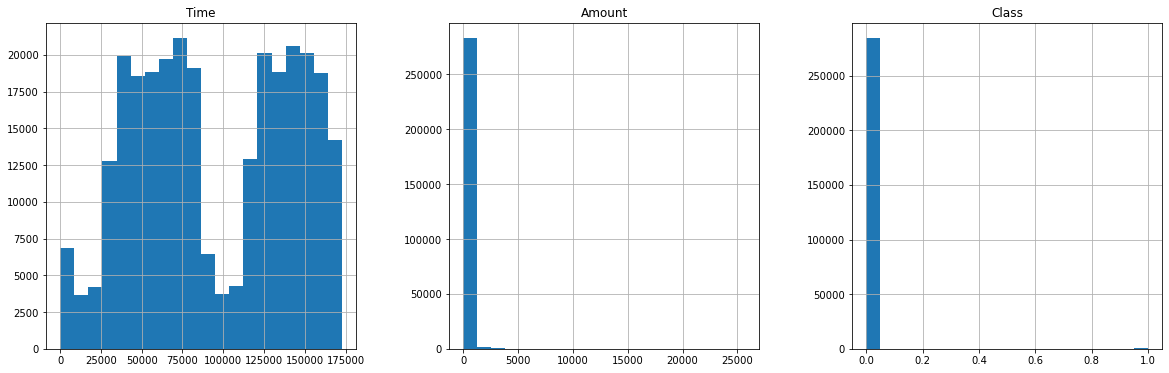

In [7]:
data[['Time','Amount','Class']].hist(bins=20,figsize=(20,6),layout=(1,3));

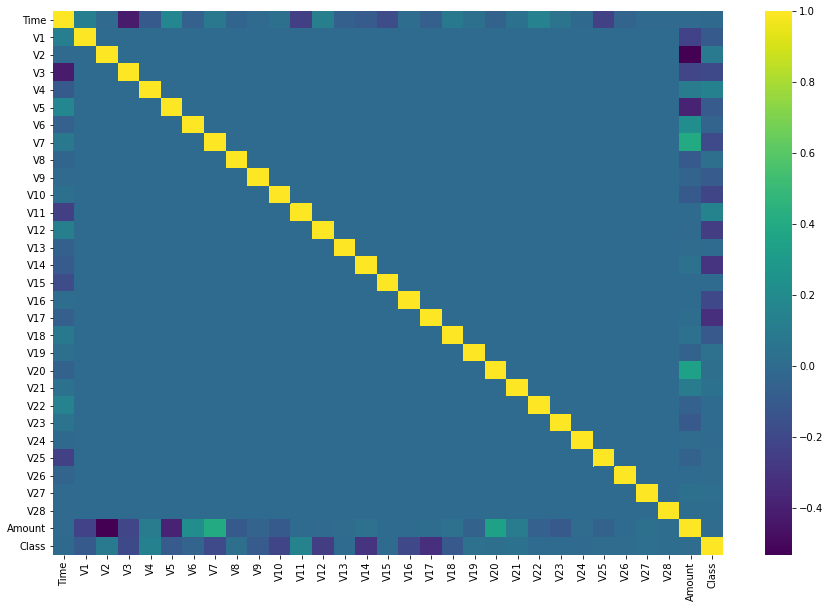

In [8]:
plt.figure(figsize=(15,10))
sns.heatmap(data.corr(),cmap='viridis');

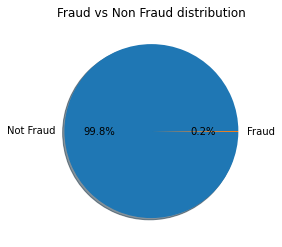

In [9]:
a = data['Class'].value_counts()
plt.pie(a,labels = ['Not Fraud','Fraud'],autopct='%1.1f%%', shadow=True)
plt.title('Fraud vs Non Fraud distribution');

## Data Preparation

In [10]:
X = data.iloc[:,:-1]
y = data['Class']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 27)

In [12]:
scaler = StandardScaler() 
X_train[['Time','Amount']] = scaler.fit_transform(X_train[['Time','Amount']])
X_test[['Time','Amount']] = scaler.transform(X_test[['Time','Amount']])

In [13]:
#using dummy classifier
from sklearn.dummy import DummyClassifier
dummy = DummyClassifier(strategy='most_frequent').fit(X_train,y_train)
dummy.score(X_test,y_test)

0.9981461194910255

**Upsampling/Oversampling**

In [14]:
train = pd.concat([X_train,y_train],axis=1)
train.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
264873,1.407093,-0.395578,1.489129,-0.833442,-0.224271,0.369444,-1.453886,0.796593,-0.060403,0.338270,...,0.231624,0.955194,-0.172092,-0.041050,-0.313444,-0.174301,0.064657,-0.036960,-0.342275,0
163821,0.451127,1.950487,0.002312,-1.761814,1.232470,0.523175,-0.650657,0.504231,-0.200857,0.116805,...,0.086306,0.326297,-0.068839,-0.416589,0.426044,-0.486299,-0.031266,-0.072543,-0.199543,0
72083,-0.847726,1.105167,-0.166253,0.569520,0.681043,-0.259189,0.642792,-0.437034,0.356746,0.441417,...,0.009073,0.293023,-0.028688,-0.242206,0.389813,0.482852,0.010705,-0.008399,-0.349231,0
196949,0.778241,1.805238,0.961264,-1.717212,4.094625,0.938666,-0.227785,0.152911,0.066753,-1.073784,...,-0.137875,-0.450959,0.098530,-0.662272,-0.150154,-0.098852,-0.000030,0.017622,-0.201742,0
126213,-0.354928,0.835421,-1.191847,0.578455,0.586101,-1.236663,0.194617,-0.532404,0.061561,-0.734344,...,-0.072349,-0.109154,-0.308356,0.011968,0.461350,-0.244810,0.031845,0.060910,0.594317,0


In [15]:
not_fraud = train[train['Class']==0]
fraud = train[train['Class']==1]

#upscaling minority
fraud_upsampled = resample(fraud, replace= True, n_samples = len(not_fraud), random_state = 27)

In [16]:
upsampled_data = pd.concat([not_fraud,fraud_upsampled]) 
upsampled_data['Class'].value_counts()

1    213245
0    213245
Name: Class, dtype: int64

In [17]:
upsampled_data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
264873,1.407093,-0.395578,1.489129,-0.833442,-0.224271,0.369444,-1.453886,0.796593,-0.060403,0.338270,...,0.231624,0.955194,-0.172092,-0.041050,-0.313444,-0.174301,0.064657,-0.036960,-0.342275,0
163821,0.451127,1.950487,0.002312,-1.761814,1.232470,0.523175,-0.650657,0.504231,-0.200857,0.116805,...,0.086306,0.326297,-0.068839,-0.416589,0.426044,-0.486299,-0.031266,-0.072543,-0.199543,0
72083,-0.847726,1.105167,-0.166253,0.569520,0.681043,-0.259189,0.642792,-0.437034,0.356746,0.441417,...,0.009073,0.293023,-0.028688,-0.242206,0.389813,0.482852,0.010705,-0.008399,-0.349231,0
196949,0.778241,1.805238,0.961264,-1.717212,4.094625,0.938666,-0.227785,0.152911,0.066753,-1.073784,...,-0.137875,-0.450959,0.098530,-0.662272,-0.150154,-0.098852,-0.000030,0.017622,-0.201742,0
126213,-0.354928,0.835421,-1.191847,0.578455,0.586101,-1.236663,0.194617,-0.532404,0.061561,-0.734344,...,-0.072349,-0.109154,-0.308356,0.011968,0.461350,-0.244810,0.031845,0.060910,0.594317,0


In [18]:
### Logistic Regression with upscaled data
classifier = LogisticRegression()
X_train = upsampled_data.iloc[:,:-1]
y_train = upsampled_data['Class']

classifier = LogisticRegression(solver='liblinear')
classifier.fit(X_train,y_train)

upsampled_pred = classifier.predict(X_test)

In [19]:
classifier.score(X_train,y_train)

0.9519308776290183

In [20]:
classifier.score(X_test,y_test)

0.9783573495126542

In [21]:
print('Classification report for Logistic Regression')
print(classification_report(y_test,upsampled_pred))

Classification report for Logistic Regression
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     71070
           1       0.07      0.89      0.13       132

    accuracy                           0.98     71202
   macro avg       0.54      0.93      0.56     71202
weighted avg       1.00      0.98      0.99     71202



In [22]:
# confusion matrix
pd.DataFrame(confusion_matrix(y_test,upsampled_pred),columns = ['Predicted 0','Predicted 1'], index=['Actual 0','Actual 1'])

,Predicted 0,Predicted 1
Actual 0,69544,1526
Actual 1,15,117


**What we want to do is minimize the fraudulent transaction being marked as non fraudulent** 

**Downsampling/Undersampled**

In [23]:
#downscaling majority
not_fraud_downsampled = resample(not_fraud, replace = False, n_samples = len(fraud), random_state=27)

In [24]:
downsampled_data = pd.concat([fraud,not_fraud_downsampled]) 
downsampled_data['Class'].value_counts()

1    360
0    360
Name: Class, dtype: int64

In [25]:
### Logistic Regression with downscaled data
classifier = LogisticRegression()
X_train = downsampled_data.iloc[:,:-1]
y_train = downsampled_data['Class']

classifier = LogisticRegression(solver='liblinear')
classifier.fit(X_train,y_train)

downsampled_pred = classifier.predict(X_test)

In [26]:
classifier.score(X_train,y_train)

0.9541666666666667

In [27]:
classifier.score(X_test,y_test)

0.9650571613156934

In [28]:
print('Classification report for Logistic Regression for downsampled data')
print(classification_report(y_test,downsampled_pred))

Classification report for Logistic Regression for downsampled data
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     71070
           1       0.05      0.89      0.09       132

    accuracy                           0.97     71202
   macro avg       0.52      0.93      0.53     71202
weighted avg       1.00      0.97      0.98     71202



In [29]:
# confusion matrix for downsampled data
pd.DataFrame(confusion_matrix(y_test,downsampled_pred),columns = ['Predicted 0','Predicted 1'], index=['Actual 0','Actual 1'])

,Predicted 0,Predicted 1
Actual 0,68597,2473
Actual 1,15,117


### Generate Synthetic Samples
***SMOTE(Synthetic Minority Oversampling Technique***

In [30]:
from imblearn.over_sampling import SMOTE

In [31]:
sm = SMOTE(random_state=27)
X_train,y_train = sm.fit_sample(train.iloc[:,:-1],train['Class'])

In [32]:
y_train.value_counts()

1    213245
0    213245
Name: Class, dtype: int64

In [33]:
### Logistic Regression with smote data
classifier = LogisticRegression()

classifier = LogisticRegression(solver='liblinear')
classifier.fit(X_train,y_train)

smote_pred = classifier.predict(X_test)

In [34]:
classifier.score(X_train,y_train)

0.9514033154352974

In [35]:
classifier.score(X_test,y_test)

0.9767000926940255

In [36]:
print('Classification report for Logistic Regression for smote data')
print(classification_report(y_test,smote_pred))

Classification report for Logistic Regression for smote data
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     71070
           1       0.07      0.89      0.12       132

    accuracy                           0.98     71202
   macro avg       0.53      0.93      0.56     71202
weighted avg       1.00      0.98      0.99     71202



In [37]:
# confusion matrix for smote data
pd.DataFrame(confusion_matrix(y_test,smote_pred),columns = ['Predicted 0','Predicted 1'], index=['Actual 0','Actual 1'])

,Predicted 0,Predicted 1
Actual 0,69426,1644
Actual 1,15,117


## RandomForestClassifier

In [38]:
X_train = downsampled_data.iloc[:,:-1]
y_train = downsampled_data['Class']

In [39]:
classifier = RandomForestClassifier()

In [40]:
classifier.fit(X_train, y_train)

RandomForestClassifier()

In [41]:
classifier.score(X_train, y_train)

1.0

In [42]:
classifier.score(X_test,y_test)

0.9808011010926659

In [43]:
rfc_pred = classifier.predict(X_test)

In [44]:
print('Classification report')
print(classification_report(y_test,rfc_pred))

Classification report
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     71070
           1       0.08      0.87      0.14       132

    accuracy                           0.98     71202
   macro avg       0.54      0.93      0.57     71202
weighted avg       1.00      0.98      0.99     71202



In [45]:
# confusion matrix for smote data
pd.DataFrame(confusion_matrix(y_test,rfc_pred),columns = ['Predicted 0','Predicted 1'], index=['Actual 0','Actual 1'])

,Predicted 0,Predicted 1
Actual 0,69720,1350
Actual 1,17,115


**RandomizedSearchCV**

In [46]:
params = {'criterion' : ['gini','entropy'],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

In [47]:
rf_random = RandomizedSearchCV(RandomForestClassifier(),param_distributions=params, cv = 10, random_state=42, n_jobs = -1)

In [48]:
rf_random.fit(X_train,y_train)

RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42)

In [49]:
rf_random.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=20, n_estimators=2000)

In [50]:
rf_random.best_score_

0.9486111111111111

In [51]:
rfc = rf_random.best_estimator_

In [52]:
rfc.fit(X_train,y_train)

RandomForestClassifier(criterion='entropy', max_depth=20, n_estimators=2000)

In [53]:
rfc.score(X_train,y_train)

1.0

In [54]:
rfc.score(X_test,y_test)

0.9856886042526896

In [55]:
r_rfc_pred = rfc.predict(X_test)

In [56]:
print('Classification report')
print(classification_report(y_test,r_rfc_pred))

Classification report
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     71070
           1       0.10      0.87      0.18       132

    accuracy                           0.99     71202
   macro avg       0.55      0.93      0.59     71202
weighted avg       1.00      0.99      0.99     71202



In [57]:
# confusion matrix
pd.DataFrame(confusion_matrix(y_test,r_rfc_pred),columns = ['Predicted 0','Predicted 1'], index=['Actual 0','Actual 1'])

,Predicted 0,Predicted 1
Actual 0,70068,1002
Actual 1,17,115


**GridSearchCV**

In [58]:
params = {'criterion' : ['gini','entropy'],
    'max_depth': [10, 50, 100, None],
 'min_samples_leaf': [1, 5],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 1000, 2000]}

In [59]:
grid = GridSearchCV(RandomForestClassifier(),param_grid=params, cv = 3, n_jobs = -1,verbose=1,scoring='roc_auc')

In [60]:
grid.fit(X_train,y_train)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 50, 100, None],
                         'min_samples_leaf': [1, 5],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [200, 1000, 2000]},
             scoring='roc_auc', verbose=1)

In [61]:
grid.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=10, min_samples_leaf=5,
                       min_samples_split=10, n_estimators=200)

In [62]:
grid.best_score_

0.9828472222222221

In [63]:
rfc = grid.best_estimator_

In [64]:
rfc.fit(X_train,y_train)

RandomForestClassifier(criterion='entropy', max_depth=10, min_samples_leaf=5,
                       min_samples_split=10, n_estimators=200)

In [65]:
rfc.score(X_train,y_train)

0.9722222222222222

In [66]:
rfc.score(X_test,y_test)

0.9885396477627033

In [67]:
r_rfc_pred = rfc.predict(X_test)

In [68]:
print('Classification report')
print(classification_report(y_test,r_rfc_pred))

Classification report
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     71070
           1       0.12      0.86      0.22       132

    accuracy                           0.99     71202
   macro avg       0.56      0.93      0.61     71202
weighted avg       1.00      0.99      0.99     71202



In [69]:
# confusion matrix
pd.DataFrame(confusion_matrix(y_test,r_rfc_pred),columns = ['Predicted 0','Predicted 1'], index=['Actual 0','Actual 1'])

,Predicted 0,Predicted 1
Actual 0,70272,798
Actual 1,18,114


## XGBoost 

In [70]:
classifier = XGBClassifier(use_label_encoder=False)

In [71]:
classifier.fit(X_train, y_train)

[20:57:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [72]:
classifier.score(X_train, y_train)

1.0

In [73]:
classifier.score(X_test, y_test)

0.9679222493750176

In [74]:
pred = classifier.predict(X_test)

In [75]:
print('Classification report')
print(classification_report(y_test,pred))

Classification report
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     71070
           1       0.05      0.90      0.09       132

    accuracy                           0.97     71202
   macro avg       0.52      0.93      0.54     71202
weighted avg       1.00      0.97      0.98     71202



In [76]:
# confusion matrix
pd.DataFrame(confusion_matrix(y_test,pred),columns = ['Predicted 0','Predicted 1'], index=['Actual 0','Actual 1'])

,Predicted 0,Predicted 1
Actual 0,68799,2271
Actual 1,13,119


In [77]:
param_tuning = {
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7, 10],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [100, 200, 500]
    }

In [78]:
grid = GridSearchCV(XGBClassifier(use_label_encoder=False), param_grid=param_tuning, cv = 5, n_jobs = -1, verbose = 1, scoring='roc_auc')

In [79]:
grid.fit(X_train,y_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
[21:04:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs...
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, use_label_encoder=False,
                                     validate_parameters=

In [80]:
grid.best_score_

0.985300925925926

In [81]:
classifier = grid.best_estimator_

In [82]:
classifier.score(X_train, y_train)

0.9902777777777778

In [83]:
classifier.score(X_test, y_test)

0.969130080615713

In [84]:
pred = classifier.predict(X_test)

In [85]:
print('Classification report')
print(classification_report(y_test,pred))

Classification report
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     71070
           1       0.05      0.88      0.10       132

    accuracy                           0.97     71202
   macro avg       0.53      0.92      0.54     71202
weighted avg       1.00      0.97      0.98     71202



In [86]:
# confusion matrix for smote data
pd.DataFrame(confusion_matrix(y_test,pred),columns = ['Predicted 0','Predicted 1'], index=['Actual 0','Actual 1'])

,Predicted 0,Predicted 1
Actual 0,68888,2182
Actual 1,16,116


## NBClassifier

In [87]:
classifier = GaussianNB()

In [88]:
classifier.fit(X_train, y_train)

GaussianNB()

In [89]:
classifier.score(X_train, y_train)

0.9125

In [90]:
classifier.score(X_test, y_test)

0.9712788966602062

In [91]:
pred = classifier.predict(X_test)

In [92]:
print('Classification report')
print(classification_report(y_test,pred))

Classification report
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     71070
           1       0.05      0.83      0.10       132

    accuracy                           0.97     71202
   macro avg       0.53      0.90      0.54     71202
weighted avg       1.00      0.97      0.98     71202



In [93]:
# confusion matrix
pd.DataFrame(confusion_matrix(y_test,pred),columns = ['Predicted 0','Predicted 1'], index=['Actual 0','Actual 1'])

,Predicted 0,Predicted 1
Actual 0,69047,2023
Actual 1,22,110


## SVC

In [94]:
classifier = SVC(kernel='rbf', probability=True)

In [95]:
classifier.fit(X_train, y_train)

SVC(probability=True)

In [96]:
classifier.score(X_train, y_train)

0.9472222222222222

In [97]:
classifier.score(X_test, y_test)

0.9847476194488919

In [98]:
pred = classifier.predict(X_test)

In [99]:
print('Classification report')
print(classification_report(y_test,pred))

Classification report
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     71070
           1       0.10      0.86      0.17       132

    accuracy                           0.98     71202
   macro avg       0.55      0.92      0.58     71202
weighted avg       1.00      0.98      0.99     71202



In [100]:
# confusion matrix
pd.DataFrame(confusion_matrix(y_test,pred),columns = ['Predicted 0','Predicted 1'], index=['Actual 0','Actual 1'])

,Predicted 0,Predicted 1
Actual 0,70002,1068
Actual 1,18,114


**GridSearchCV**

In [101]:
params = {'C':[1,10,50,100,500,1000,2000],
         'gamma':[0.1,0.01,0.001]}
grid = GridSearchCV(SVC(kernel='rbf', probability=True), param_grid= params, cv = 5, scoring='roc_auc', verbose = 10, n_jobs=-1)

In [102]:
grid.fit(X_train,y_train)

Fitting 5 folds for each of 21 candidates, totalling 105 fits


GridSearchCV(cv=5, estimator=SVC(probability=True), n_jobs=-1,
             param_grid={'C': [1, 10, 50, 100, 500, 1000, 2000],
                         'gamma': [0.1, 0.01, 0.001]},
             scoring='roc_auc', verbose=10)

In [103]:
grid.best_score_

0.9845679012345678

In [104]:
classifier = grid.best_estimator_

In [105]:
classifier.score(X_train, y_train)

0.9333333333333333

In [106]:
classifier.score(X_test, y_test)

0.9943119575292829

In [107]:
pred = classifier.predict(X_test)

In [108]:
print('Classification report')
print(classification_report(y_test,pred))

Classification report
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     71070
           1       0.22      0.84      0.35       132

    accuracy                           0.99     71202
   macro avg       0.61      0.92      0.68     71202
weighted avg       1.00      0.99      1.00     71202



In [109]:
# confusion matrix for smote data
pd.DataFrame(confusion_matrix(y_test,pred),columns = ['Predicted 0','Predicted 1'], index=['Actual 0','Actual 1'])

,Predicted 0,Predicted 1
Actual 0,70686,384
Actual 1,21,111
